In [22]:
from PIL import Image
import numpy as np
import os

def load_data(*path: str, labels: list, skip: bool = True) -> np.ndarray:
    """
    Loads data from a given path and returns a numpy array with the image and label of each file.

    Parameters:
    -----------
    path: str -> Path to the data folder. (can be multiple paths)
    labels: list -> List of labels for each path.
    skip: bool -> Skip files that are not images or cannot be read. (default: True)

    Returns:
    --------
    data_array: np.ndarray -> Numpy array with the image and label of each file.
    """

    # list to store the data. 
    data_array = []
    skipped_files = 0 # Number of skipped files.

    # ---------------------------------------------------
    # Check if the number of paths and labels are equal.
    # If not equal raise an error.
    # ---------------------------------------------------
    if len(path) == len(labels):

        # Loop through the paths and labels.
        for p, l in zip(path, labels):

            # --------------------------
            # Check if the path exists.
            # If not raise an error.
            # --------------------------    
            if os.path.exists(p):
                
                # ----------------------------------------------
                # Loop through the files in the path.
                # Append the image and label to the list.
                # ----------------------------------------------
                for file in os.listdir(p):
                    # Try to catch errors when reading the image.
                    try:
                        # Append the image and label to the list.
                        data_array.append([Image.open(os.path.join(p, file)), l])

                    except Image.UnidentifiedImageError as e:
                        # If skip is True, skip the file.
                        if skip:
                            skipped_files += 1 
                        else:
                            raise e
            else:
                raise FileNotFoundError("Path does not exist")
    else:
        raise ValueError("Number of paths and labels must be equal")
    
    if skipped_files > 0:
        print(f"Skipped {skipped_files} files")

    # Return the numpy array.
    return np.array(data_array, dtype=object)


def resize_images(images: np.array, size: tuple) -> np.array:
    """
    Resizes images in a numpy array.

    Parameters:
    -----------
    images: np.array -> Numpy array with images.
    size: tuple -> Size to resize the images. (width, height)

    Returns:
    --------
    images: np.array -> Numpy array with the resized images.
    """
    
    # Loop through the images and resize them.
    for index, image in enumerate(images):
        images[index][0] = image[0].resize(size)

    # Retruns the numpy array.
    return images


def convert_to_array(dataset: np.array) -> np.array:
    """
    Converts images in a numpy array to numpy arrays.

    Parameters:
    -----------
    dataset: np.array -> Numpy array with images.

    Returns:
    --------
    dataset: np.array -> Numpy array with the images converted to numpy arrays.
    """

    # Loop through the images and convert them to numpy arrays. 
    for index, image in enumerate(dataset):
        dataset[index][0] = np.array(image[0]).astype(np.float32)

    # Return the numpy array.
    return dataset

def normalize_images(images: np.ndarray) -> np.ndarray:
    """
    Normalizes the images in a numpy array.

    Parameters:
    -----------
    images: np.ndarray -> Numpy array with images.

    Returns:
    --------
    images: np.ndarray -> Numpy array with normalized images.
    """

    list = []

    # Loop through the images and normalize them.
    for index, image in enumerate(images):
        list.append([np.asarray(image[0] / 255.0).astype(np.float32), image[1]])

    # Return the numpy array.
    return list

Skipped 389 files


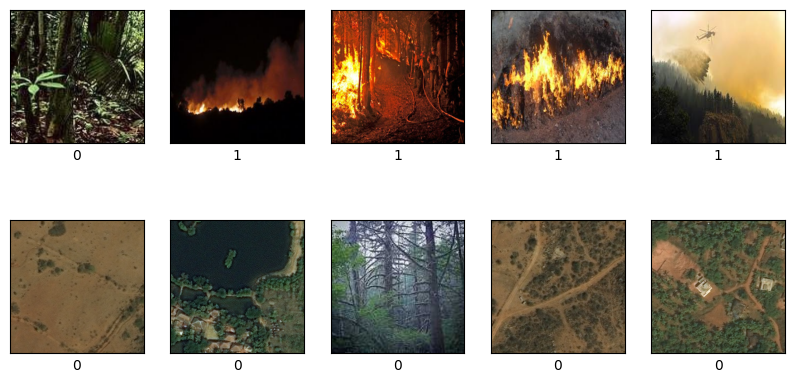

dataset len: 4773
dataset shape: (4773, 2)
dataset fire images: 0
dataset forest images: 0


In [24]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

path_fire = './Data/fire/fire/fire-images/'
path_forest = './Data/fire/fire/forest-images/'

# ------------------------------
# Load the data.
# Resize the images to 256x256.
# ------------------------------
dataset = load_data(path_fire, path_forest, labels=[1, 0])
dataset = resize_images(dataset, (256, 256))

# Shuffle the dataset.
np.random.shuffle(dataset)

# Sample 10 images from the dataset.
plt.figure(figsize=(10, 5))
for index, image in enumerate(dataset[:10]):
    plt.subplot(2, 5, index+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image[0], cmap=plt.cm.binary)
    plt.xlabel(image[1])
plt.show()

# ------------------------
# Print the dataset info.
# ------------------------ 
print(f"dataset len: {len(dataset)}")
print(f"dataset shape: {dataset.shape}")
print(f"dataset fire images: {len([index for index in dataset if index[1] == '1'])}")
print(f"dataset forest images: {len([index for index in dataset if index[1] == '0'])}")

# --------------------------------------------
# Convert the images to numpy arrays.
# Normalize the images.
# Split the dataset into train and test sets.
# --------------------------------------------
dataset = convert_to_array(dataset)
dataset = normalize_images(dataset)
X_train, X_test, y_train, y_test = train_test_split(dataset[:][0], dataset[:][1], test_size=0.2, random_state=42)

In [31]:
print(X_train.shape)

(1, 256, 256, 3)


In [27]:
from keras.models import Sequential
from keras import layers

import tensorflow as tf

X_train = np.asarray(X_train).astype(np.float32)

 
model = Sequential([
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(units=5, activation='softmax'),
    layers.Dense(units=1024, activation='relu'),
])

# Building and training the model. 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, validation_split=0.2)

ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.

In [77]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import os

def clean_dataset(path: str) -> None:
    """
    Removes images that cannot be read from dataset.

    Parameters:
    -----------
    path: str -> Path to the dataset.

    Returns:
    --------
    None
    """

    # Check if the path exists.
    if not os.path.exists(path):
        raise FileNotFoundError("Path does not exist")

    # ---------------------------------------
    # Loop through the folders in the path.
    # Loop through the files in the folder.
    # Removes the files that cannot be read.
    # --------------------------------------- 
    for folder in os.listdir(path):

        # Number of removed files.
        removed_files = 0

        for file in os.listdir(os.path.join(path, folder)):
            try:
                # Try to open the image.
                image = Image.open(os.path.join(path, folder, file))
            except Image.UnidentifiedImageError:
                # If the image cannot be read, removes it.
                os.remove(os.path.join(path, folder, file))
                removed_files += 1
        
        print(f"Removed {removed_files} files from {folder}")
    

def sample_images(dataset: any, batch_size: int = 32, samples: int = 10, labels: list = None) -> None:
    """
    Samples images from a given dataset.

    Parameters:
    -----------
    dataset: any -> Dataset to sample images from.
    batch_size: int -> Batch size of the dataset. (default: 32)
    samples: int -> Number of samples to take. (default: 10)
    labels: list -> List of labels for each image. (default: None)

    Returns:
    --------
    None
    """

    # Check if the number of samples is less or equal to the batch size.
    if samples > batch_size:
        raise ValueError("Samples must be less or equal to batch size")

    # Number of columns in the plot.
    num_cols = 5
    num_rows = samples // num_cols

    # ----------------------------------------
    # Gets a batch from the dataset.
    # Converts the labels to a list.
    # Creates a figure to plot the images on.
    # ----------------------------------------
    batch = dataset.as_numpy_iterator().next()
    label_list = batch[1].tolist()
    fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))

    # ---------------------------------------------------
    # Check if labels are given.
    # If given replaces the labels with the given label.
    # ---------------------------------------------------
    if labels:
        for index, label in enumerate(label_list):
            try:
                label_list[index] = labels[label]
            except IndexError:
                print("Could not find label")
    
    # Plot the images.
    try:
        for index, image in enumerate(batch[0][:samples]):
            ax[index // num_cols, index % num_cols].imshow(image.astype(int))
            ax[index // num_cols, index % num_cols].set_title(label_list[index])
    except IndexError:
        print("Could not sample all images.")

    plt.show()



In [33]:
import tensorflow as tf
from keras.utils import image_dataset_from_directory

data = image_dataset_from_directory(directory='Data/fire/fire', image_size=(256, 256), batch_size=32, seed=42)
sample_images(data, samples=10, labels=['fire', 'forest'])


Found 4773 files belonging to 2 classes.
